# Part B

# ViT ( Encoder ) + GPT-2 ( Decoder )  Image captioning model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing the additinal Libraries required

In [ ]:
%pip install -U accelerate
%pip install datasets
%pip install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 5.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

Importing all the required libraries

In [ ]:
import pandas as pd
import os
from PIL import Image
import numpy as np
import cv2
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader
import datasets


from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTImageProcessor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator


os.environ["WANDB_DISABLED"] = "true"


Checking the GPU Environment

In [ ]:
if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())


else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.


# Pre Processing

Function for handling special Tokens

In [ ]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs
AutoTokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens

Loading the Feature extractor and tokenizer from transforers library

In [ ]:
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer.pad_token = tokenizer.unk_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

Normalisation function for images

In [ ]:
def normalize(image_data):
    image = np.array(image_data)
    tensor_image = torch.tensor(image)

    # Normalize the tensor
    normalized_tensor = (tensor_image - torch.min(tensor_image)) / (torch.max(tensor_image) - torch.min(tensor_image))

    return normalized_tensor

Transfrom for pre-processing images

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(normalize), # Resize the image to 224x224

])

Loading the captions file of training dataset

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/dl_data/train.csv')
df_train.head()

,Unnamed: 0,filename,caption
0,0,train_1.jpg,A white round plate is on a table with a plast...
1,1,train_2.jpg,There are four small pizzas on a brown wooden ...
2,2,train_3.jpg,A black and white cat is sitting in a white ch...
3,3,train_4.jpg,A boy is practicing his skateboard moves outsi...
4,4,train_5.jpg,Two brown horses are standing together outside...


from matplotlib import pyplot as plt
_df_18['Unnamed: 0'].plot(kind='hist', bins=20, title='Unnamed: 0')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_19.groupby('filename').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_20.groupby('caption').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Unnamed: 0']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Unnamed: 0'}, axis=1)
              .sort_values('Unnamed: 0', ascending=True))
  xs = counted['Unnamed: 0']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_21.sort_values('Unnamed: 0', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('filename')):
  _plot_series(series, series_name, i)
  fig.legend(title='filename', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Unnamed: 0')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Unnamed: 0']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Unnamed: 0'}, axis=1)
              .sort_values('Unnamed: 0', ascending=True))
  xs = counted['Unnamed: 0']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_22.sort_values('Unnamed: 0', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('caption')):
  _plot_series(series, series_name, i)
  fig.legend(title='caption', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Unnamed: 0')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_23['Unnamed: 0'].plot(kind='line', figsize=(8, 4), title='Unnamed: 0')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['caption'].value_counts()
    for x_label, grp in _df_24.groupby('filename')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('filename')
_ = plt.ylabel('caption')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_25['filename'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_25, x='Unnamed: 0', y='filename', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_26['caption'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_26, x='Unnamed: 0', y='caption', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Loading the captions file of test dataset

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/dl_data/test.csv')
df_test.head()

,Unnamed: 0,filename,caption
0,0,test_1.jpg,A large building with bars on the windows in f...
1,1,test_2.jpg,A person is skiing through the snow. There is ...
2,2,test_3.jpg,There is a bed in a room against a wall. There...
3,3,test_4.jpg,A black and red train is on the tracks and has...
4,4,test_5.jpg,A white and yellow public transportation bus w...


from matplotlib import pyplot as plt
_df_0['Unnamed: 0'].plot(kind='hist', bins=20, title='Unnamed: 0')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('filename').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('caption').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Unnamed: 0']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Unnamed: 0'}, axis=1)
              .sort_values('Unnamed: 0', ascending=True))
  xs = counted['Unnamed: 0']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Unnamed: 0', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('filename')):
  _plot_series(series, series_name, i)
  fig.legend(title='filename', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Unnamed: 0')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Unnamed: 0']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Unnamed: 0'}, axis=1)
              .sort_values('Unnamed: 0', ascending=True))
  xs = counted['Unnamed: 0']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('Unnamed: 0', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('caption')):
  _plot_series(series, series_name, i)
  fig.legend(title='caption', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Unnamed: 0')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['Unnamed: 0'].plot(kind='line', figsize=(8, 4), title='Unnamed: 0')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['caption'].value_counts()
    for x_label, grp in _df_6.groupby('filename')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('filename')
_ = plt.ylabel('caption')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_7['filename'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_7, x='Unnamed: 0', y='filename', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['caption'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='Unnamed: 0', y='caption', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Loading the captions file of validation dataset

In [ ]:
df_val = pd.read_csv('/content/drive/MyDrive/dl_data/val.csv')
df_val.head()

,Unnamed: 0,filename,caption
0,0,val_1.jpg,A group of men stand in the snow with skis. Th...
1,1,val_2.jpg,A small short haired brown dog walks down the ...
2,2,val_3.jpg,There are two elephants standing on the ground...
3,3,val_4.jpg,A very detailed hotel room. The bedding is blu...
4,4,val_5.jpg,Beautiful elephants are showed at a festival o...


from matplotlib import pyplot as plt
_df_9['Unnamed: 0'].plot(kind='hist', bins=20, title='Unnamed: 0')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_10.groupby('filename').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_11.groupby('caption').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Unnamed: 0']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Unnamed: 0'}, axis=1)
              .sort_values('Unnamed: 0', ascending=True))
  xs = counted['Unnamed: 0']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('Unnamed: 0', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('filename')):
  _plot_series(series, series_name, i)
  fig.legend(title='filename', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Unnamed: 0')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Unnamed: 0']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Unnamed: 0'}, axis=1)
              .sort_values('Unnamed: 0', ascending=True))
  xs = counted['Unnamed: 0']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('Unnamed: 0', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('caption')):
  _plot_series(series, series_name, i)
  fig.legend(title='caption', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Unnamed: 0')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_14['Unnamed: 0'].plot(kind='line', figsize=(8, 4), title='Unnamed: 0')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['caption'].value_counts()
    for x_label, grp in _df_15.groupby('filename')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('filename')
_ = plt.ylabel('caption')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['filename'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='Unnamed: 0', y='filename', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['caption'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='Unnamed: 0', y='caption', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Dataset class for creating the dataset

In [ ]:
class ImgDataset(Dataset):
    def __init__(self, df, root_dir, tokenizer, feature_extractor, max_length=239,transform=None): #max-length known from the Part-A of the project
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor

        # Initialize max_caption_length to 0
        self.max_caption_length = max_length


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        caption = self.df.caption.iloc[idx]
        image = self.df.filename.iloc[idx]
        img_path = os.path.join(self.root_dir, image)
        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        pixel_values = self.feature_extractor(img, return_tensors="pt").pixel_values

        # Tokenize caption and pad/truncate to maximum caption length
        tokenized_caption = self.tokenizer(
            caption,
            padding='max_length',
            max_length=self.max_caption_length,
            truncation=True,
            return_tensors='pt'
        )

        # Get input ids of tokenized caption
        input_ids = tokenized_caption['input_ids'].squeeze()

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": input_ids}

        return encoding


Creating an instance of training dataset

In [ ]:
train_dataset = ImgDataset(df_train, root_dir = "/content/drive/MyDrive/dl_data/train",tokenizer=tokenizer,feature_extractor = feature_extractor ,transform = transform)

Creating an instance of validation dataset

In [ ]:
val_dataset = ImgDataset(df_val, root_dir = "/content/drive/MyDrive/dl_data/val",tokenizer=tokenizer,feature_extractor = feature_extractor ,transform = transform)

Creating an instance of test dataset

In [ ]:
test_dataset = ImgDataset(df_test, root_dir = "/content/drive/MyDrive/dl_data/test",tokenizer=tokenizer,feature_extractor = feature_extractor ,transform = transform)

# MODEL Creating

Loading the pre-trained model from transformers

In [ ]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
model = model.to('cuda')

config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

Setting the model configuration for fine-tuning on our dataset

In [ ]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id

model.config.vocab_size = 8639 
model.config.eos_token_id = tokenizer.sep_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.max_length = 239
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

Setting the training Arguments for seq2seq trainer for fine-tuning

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir='VIT_large_gpt2',
    per_device_train_batch_size= 8,
    per_device_eval_batch_size= 8,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    eval_steps = 715,
    logging_steps=1024,
    save_steps=2048,
    warmup_steps=1024,
    learning_rate = 5e-5,
    num_train_epochs = 3, #TRAIN_EPOCHS
    overwrite_output_dir=True,
    save_total_limit=1,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


# Model Training

Function for Evaluation metrics

In [ ]:
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rougeL"])["rougeL"].mid

    return {
        "rougeL_precision": round(rouge_output.precision, 4),
        "rougeL_recall": round(rouge_output.recall, 4),
        "rougeL_fmeasure": round(rouge_output.fmeasure, 4),
    }

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Fine-tuning the model and validating on validation dataset

In [ ]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rougel Precision,Rougel Recall,Rougel Fmeasure
1,No log,0.738273,0.242300,0.269000,0.245400
2,0.840000,0.716876,0.264500,0.224200,0.233200
3,0.687600,0.709892,0.233700,0.259000,0.236300


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 239, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Removed shared tensor {'decoder.lm_head.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading


TrainOutput(global_step=2145, training_loss=0.7604140026030285, metrics={'train_runtime': 6385.3833, 'train_samples_per_second': 2.685, 'train_steps_per_second': 0.336, 'total_flos': 3.0940534132545946e+18, 'train_loss': 0.7604140026030285, 'epoch': 3.0})

Plotting the Rouge_l scores

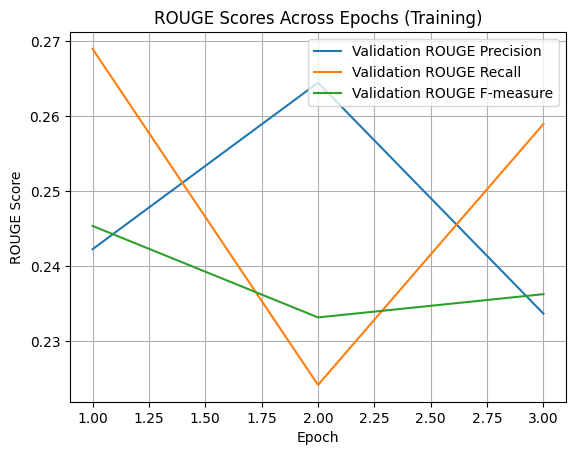

In [ ]:
eval_rouge_precision = [0.2423, 0.2645, 0.2337]
eval_rouge_recall = [0.2690, 0.2242, 0.2590]
eval_rouge_fmeasure = [0.2454, 0.2332,0.2363]
epochs = [1, 2, 3]


plt.plot(epochs, eval_rouge_precision, label='Validation ROUGE Precision')
plt.plot(epochs, eval_rouge_recall, label='Validation ROUGE Recall')
plt.plot(epochs, eval_rouge_fmeasure, label='Validation ROUGE F-measure')

plt.xlabel('Epoch')
plt.ylabel('ROUGE Score')
plt.title('ROUGE Scores Across Epochs (Training)')
plt.legend()
plt.grid(True)
plt.show()

# Model Evaluation

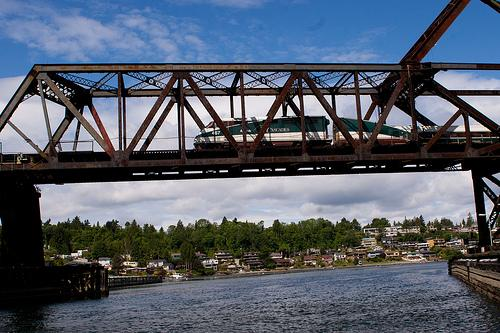

In [ ]:
img =  Image.open("/content/drive/MyDrive/dl_data/test/test_109.jpg").convert("RGB")
img

In [ ]:
gen_kwargs = {"max_length": 239, "num_beams": 4}
pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values
pixel_values = pixel_values.to('cuda')

output_ids = model.generate(pixel_values, **gen_kwargs)

preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
preds = [pred.strip() for pred in preds]
preds

['There is a train on the tracks. The train is red and white. There is a bridge over the bridge. The bridge is over a body of water. There are trees on the side of the river. The water is calm. The sky above the bridge is blue.']

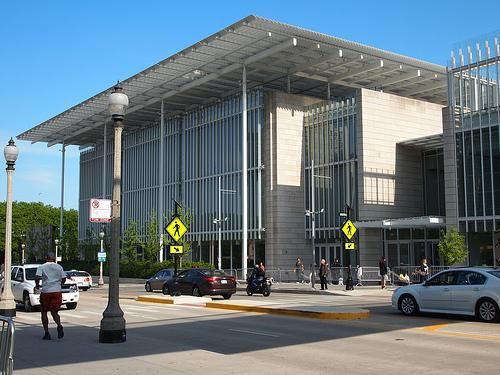

In [ ]:
img =  Image.open("/content/drive/MyDrive/dl_data/test/test_1.jpg").convert("RGB")
img

In [ ]:
gen_kwargs = {"max_length": 239, "num_beams": 4}
pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values
pixel_values = pixel_values.to('cuda')

output_ids = model.generate(pixel_values, **gen_kwargs)

preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
preds = [pred.strip() for pred in preds]
preds

['A man is walking down the street in front of a building. He is wearing a black jacket and black pants. He has a black backpack on his back. There are cars parked on the side of the street near the building. There is a red light on the street next to the buildings.']

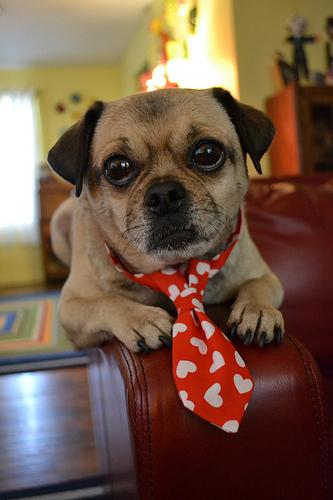

In [ ]:
img =  Image.open("/content/drive/MyDrive/dl_data/test/test_100.jpg").convert("RGB")
img

In [ ]:
gen_kwargs = {"max_length": 239, "num_beams": 4}
pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values
pixel_values = pixel_values.to('cuda')

output_ids = model.generate(pixel_values, **gen_kwargs)

preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
preds = [pred.strip() for pred in preds]
preds

["a dog is sitting on a chair. the dog has a collar on it's neck. the collar is black and white. there is a brown dog sitting on the chair."]

In [ ]:
all_preds= []
all_labels = []
for index, row in df_test.iterrows():

    img_path = os.path.join('/content/drive/MyDrive/dl_data/test', row['filename'])
    img = Image.open(img_path).convert("RGB")
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to('cuda')

    output_ids = model.generate(pixel_values, **gen_kwargs)

    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    label = row['caption']
    all_labels.append(label)
    all_preds.append(preds)

In [ ]:
rouge_output = rouge.compute(predictions=all_preds, references=all_labels, rouge_types=["rougeL"])["rougeL"].mid
print("Rouge_L score:",rouge_output)

Rouge_L score: Score(precision=0.34065337678894314, recall=0.3006570777440464, fmeasure=0.3024853265757956)
